# Example notebook for running VaLPACa on two-photon calcium imaging data

### [VaLPACa repository](https://github.com/lyprince/valpaca)
### [Prince _et al._, 2021, _bioRxiv_](https://www.biorxiv.org/content/10.1101/2021.03.05.434105)

---
## 1. Setup

In [1]:
%matplotlib notebook

In [2]:
# @markdown ### a. Download code from the **VaLPACa** repository on GitHub.

%%bash

# ensure that we are in the main directory
cd /content 

# If the repository does not already exist, download it.
if [ -d "valpaca" ]; then
    echo "valpaca repository has already been downloaded."
else
    echo "Downloading valpaca main branch from GitHub..."
    git clone --single-branch --branch main https://github.com/linclab/valpaca --quiet
fi

In [3]:
# @markdown ### b. Install required python packages. 

print("Installing required packages...\n")
!pip --quiet install -r valpaca/requirements.txt

Installing required packages...

  Preparing metadata (setup.py) ... done


---
## 2. Prepare data

In [4]:
# @markdown ### a. Download an example session of calcium imaging data.

%%bash

# @markdown For example, we can download the session for mouse 1, session 1 from [Dandiset #37](https://gui.dandiarchive.org/#/dandiset/000037) on the DANDI Archive: `sub-408021_ses-759660390_behavior+ophys.nwb`.
mkdir -p /content/data
cd /content/data 

pip --quiet install dandi

dandi download https://dandiarchive.org/dandiset/000037/draft/files?location=sub-408021/sub-408021_ses-758519303_behavior+ophys.nwb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2023-03-28 17:25:59,116 [    INFO] NumExpr defaulting to 2 threads.
2023-03-28 17:26:09,008 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20230328172558Z-1050.log


### b. Reformat the data to run with VaLPACa. 

#### Set a few hyperparameters.

In [5]:
from pathlib import Path

FILEPATH = Path("/content/data/sub-408021_ses-758519303_behavior+ophys.nwb")
SEED = 10 # for generating the random train/valid split
PROP_TRAIN = 0.8 # proportion of the dataset to use for training

In [6]:
# @markdown #### Function to extract ROI dF/F responses and trial information from the data file.

import numpy as np
import pynwb

def extract_data(filepath=FILEPATH):

    with pynwb.NWBHDF5IO(filepath, "r") as io:
        read_nwbfile = io.read()

        # extract full fluorescence data
        dff_traces = read_nwbfile.processing["ophys"].data_interfaces["DfOverF"].roi_response_series["RoiResponseSeries"].data[()]

        # extract the stimulus dataframe
        stim_table = read_nwbfile.trials.to_dataframe(
            exclude={"gabor_orientations", "square_locations_x", "square_locations_y"}
            )
      
        # extract dt, i.e., the time elapsed between frames
        dt = np.diff(read_nwbfile.processing["ophys"].data_interfaces["DfOverF"].roi_response_series["RoiResponseSeries"].timestamps[()]).mean()
        
    # subselect trials of interest
    stim_table = stim_table.loc[
        (stim_table["stimulus_type"] == "gabors") & 
        (stim_table["gabor_frame"] == "A")
        ]
      
    # extract trial information
    trial_orientations = stim_table["gabor_mean_orientation"].to_numpy()
    trial_unexpected = stim_table["unexpected"].to_numpy()

    # extract trial starts and minimum length to reshape dF/F traces
    trial_start_frs = stim_table["start_frame_twop"].to_numpy()
    min_trial_length = np.diff(trial_start_frs).min() 
    trial_idx = (trial_start_frs + np.arange(min_trial_length).reshape(-1, 1)).T
    dff_traces = dff_traces[trial_idx]

    print("dF/F trace shape: {} trials x {} frames x {} ROIs".format(*dff_traces.shape))
    print(f"Time elapsed between frames: {dt:.4f} seconds")

    return dff_traces, trial_orientations, trial_unexpected, dt

In [7]:
# @markdown #### Function to split the data into training and validation sets.

def get_train_valid_indices(num_trials, seed=SEED, prop_train=PROP_TRAIN):

    randst = np.random.RandomState(seed)

    num_train = int(num_trials * prop_train)
    train_idxs = randst.choice(num_trials, num_train, replace=False)
    valid_mask = np.zeros(num_trials).astype(bool)
    valid_mask[train_idxs] = True
    valid_idxs = np.where(~valid_mask)[0]
    randst.shuffle(valid_idxs)

    return train_idxs, valid_idxs

In [8]:
# @markdown #### Function to package the data for VaLPACa and create the interim file.

import time
import h5py

def create_interim_h5_file(filepath=FILEPATH, overwrite=False):

    h5_name = "{}.h5".format("_".join(filepath.name.split("_")[:2])) # set an output h5 file name
    h5_path = Path(FILEPATH.parent, h5_name)

    # check if file exists
    if h5_path.is_file():
        if overwrite:
            print(f"Will overwrite interim file at location: {h5_path}")
            time.sleep(3)
        else:
            print(f"Interim file already exists at location: {h5_path}. To overwrite, set `overwrite=True`.")
            return h5_path
    else:
        print(f"Target path for the interim file: {h5_path}")

    dff_traces, trial_orientations, trial_unexpected, dt = extract_data(FILEPATH)

    train_idxs, valid_idxs = get_train_valid_indices(len(dff_traces))

    # create the dictionary that will converted into an h5 file.
    data_dict = {
        "dt"       : dt,    
        "train_idx": train_idxs,
        "valid_idx": valid_idxs,
    }

    for prefix in ["train", "valid"]:
        idxs = data_dict[f"{prefix}_idx"]
        data_dict[f"{prefix}_ori"] = trial_orientations[idxs]
        data_dict[f"{prefix}_unexp"] = trial_unexpected[idxs]
        data_dict[f"{prefix}_fluor"] = dff_traces[idxs]
    
    with h5py.File(h5_path, "w") as f:
        for key, value in data_dict.items():
            f.create_dataset(key, data=value)
      
    return h5_path

In [9]:
# @markdown #### Function to create file with added OASIS-inferred spiking data, and initialization values

import os
import sys

def add_oasis_data(interim_h5_path, overwrite=False):
    run_file = Path("utils", "preprocessing_oasis.py")
    os.environ["RUN_FILE"] = str(run_file)
    os.environ["DATA_PATH"] = str(interim_h5_path)

    final_h5_path = Path(f"{interim_h5_path}_fluor_ou_t0.1_s1.0_z_n")

    if final_h5_path.is_file():
        if overwrite:
            print(f"\nWill overwrite final file at location: {interim_h5_path}")
            time.sleep(3)
        else:
            print(f"\nFinal file already exists at location: {final_h5_path}. To overwrite, set `overwrite=True`.")
            return final_h5_path        
    else:
        print(f"\nTarget path for the final file: {final_h5_path}")

    if not interim_h5_path.is_file():
        raise OSError(f"Interim file is missing at: {interim_h5_path}.")

    %cd /content/valpaca
    !echo "python ${RUN_FILE} --data_path ${DATA_PATH} --normalize --undo_train_test_split"
    !python ${RUN_FILE} --data_path ${DATA_PATH} --normalize --undo_train_test_split

    return final_h5_path

Extract and repackage the data, using the functions defined above, for use with VaLPACa.

In [10]:
interim_h5_path = create_interim_h5_file(FILEPATH, overwrite=False)

# This step takes about 5 min.
final_h5_path = add_oasis_data(interim_h5_path, overwrite=False)

Target path for the interim file: /content/data/sub-408021_ses-758519303.h5
dF/F trace shape: 1360 trials x 45 frames x 96 ROIs
Time elapsed between frames: 0.0332 seconds

Target path for the final file: /content/data/sub-408021_ses-758519303.h5_fluor_ou_t0.1_s1.0_z_n
/content/valpaca
python utils/preprocessing_oasis.py --data_path /content/data/sub-408021_ses-758519303.h5 --normalize --undo_train_test_split
/usr/local/lib/python3.9/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 46, using nperseg = 46
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


---
## 3. Run VaLPACa
This step was shortened to take 10 min on Google Colab.  
**NOTE:** Since only 50 epochs are run, instead of 800, a best checkpoint cannot be obtained. This is because at 50 epochs, some training parameters are still warming up to their final values.

In [11]:
import os
os.environ["DATA_PATH"] = str(final_h5_path)
os.environ["MAX_EPOCHS"] = str(50) # reduced for Google Colab - should be 800

In [12]:
%%shell

cd /content/valpaca

echo -e "\nTraining VaLPACa model..."
python train_model.py \
    --restart \
    --model valpaca \
    --data_suffix fluor \
    --data_path $DATA_PATH \
    --config hyperparameters/osca/valpaca.yaml \
    --output_dir results \
    --batch_size 68 \
    --max_epochs $MAX_EPOCHS 


Training VaLPACa model...
Device: cpu

Adjusted hyperparameters:
deep_g_encoder_size=64
deep_c_encoder_size=64
obs_controller_size=128
obs_encoder_size=128

Model training results will be saved under:
results/sub-408021_ses-758519303.h5_fluor_ou_t0.1_s1.0_z_n/valpaca/dcen64_dcon32_dgen64_dgla64_dula1_fact32_gene200_ocon128_oenc128_olat128.

Valpaca model parameters:
gain=0.0078
bias=0.0000
var=0.0001
tau=0.1538

0 obs_model.encoder_init [2, 128] 256 True
1 obs_model.controller_init [128] 128 True
2 obs_model.u_prior_mean [128] 128 True
3 obs_model.u_prior_logvar [128] 128 True
4 obs_model.encoder.gru.weight_ih_l0 [384, 96] 36864 True
5 obs_model.encoder.gru.weight_hh_l0 [384, 128] 49152 True
6 obs_model.encoder.gru.bias_ih_l0 [384] 384 True
7 obs_model.encoder.gru.bias_hh_l0 [384] 384 True
8 obs_model.encoder.gru.weight_ih_l0_reverse [384, 96] 36864 True
9 obs_model.encoder.gru.weight_hh_l0_reverse [384, 128] 49152 True
10 obs_model.encoder.gru.bias_ih_l0_reverse [384] 384 True
11 obs

---
## 4. Infer latent factors
This step takes about 15 min on Google Colab.  
It is run on the **recent** checkpoint, since, as mentioned above, the **best** checkpoint cannot be reached in 50 epochs, due to the warm-up phase.

In [13]:
# @markdown ### Function to display data extracted during the latent factor inference step.

from IPython.display import SVG, display
def show_latent_factor_data(model_dir, datatype="factors"):
    datatypes = ["factors", "inputs", "traces", "train_fluor_rsq", "valid_fluor_rsq"]
    if datatype not in datatypes:
      raise ValueError(f"datatype must be one of the following: {datatypes}")
    svg_path = Path(model_dir, "figs", f"{datatype}.svg")
    display(SVG(svg_path))

In [14]:
import os
model_dir = '/content/valpaca/results/sub-408021_ses-758519303.h5_fluor_ou_t0.1_s1.0_z_n/valpaca/dcen64_dcon32_dgen64_dgla64_dula1_fact32_gene200_ocon128_oenc128_olat128'
os.environ['MODEL_DIR'] = model_dir


In [15]:
%%shell

cd /content/valpaca

echo -e "\nInferring latent factors..."
python infer_latent.py \
    --model_dir $MODEL_DIR \
    --data_suffix fluor \
    --data_path $DATA_PATH \
    --checkpoint recent 


Inferring latent factors...
Checkpoint (recent): 50
Figure saved under: /content/valpaca/results/sub-408021_ses-758519303.h5_fluor_ou_t0.1_s1.0_z_n/valpaca/dcen64_dcon32_dgen64_dgla64_dula1_fact32_gene200_ocon128_oenc128_olat128/figs/train_fluor_rsq.svg.
Figure saved under: /content/valpaca/results/sub-408021_ses-758519303.h5_fluor_ou_t0.1_s1.0_z_n/valpaca/dcen64_dcon32_dgen64_dgla64_dula1_fact32_gene200_ocon128_oenc128_olat128/figs/valid_fluor_rsq.svg.


Show some of the data extract during the latent factor inference step.

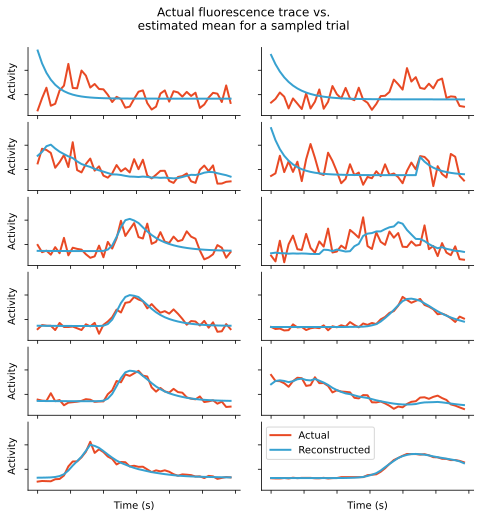

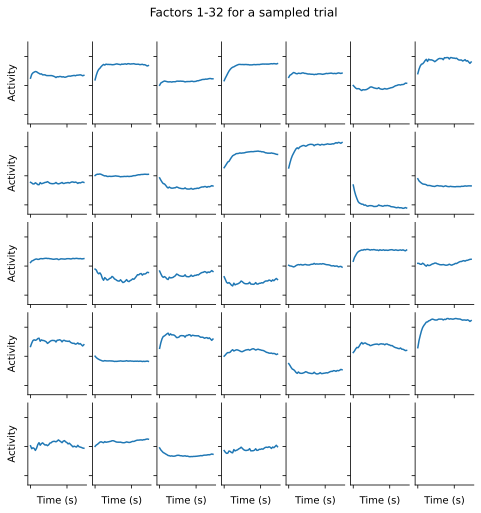

In [16]:
show_latent_factor_data(model_dir, datatype="traces")
show_latent_factor_data(model_dir, datatype="factors")

---
## 5. Run downstream analyses

In [17]:
# @markdown ### Function to display projected latent factors, organized by trial features.

from IPython.display import SVG, display
def show_proj_factors(model_dir, abc_match=True, trials=False):
    match_str = "abc" if abc_match else "du"
    suffix = "withtrials" if trials else "withproj"
    svg_path = Path(model_dir, "factors_3d_plots", f"factors_3d_orisplit_match_{match_str}_{suffix}.svg")
    display(SVG(svg_path))

In [18]:
%%shell

cd /content/valpaca

echo -e "\nRunning downstream analyses, including decoding performance on expected vs unexpected trials..."

python analysis/osca_analysis.py \
    --model_dir $MODEL_DIR \
    --data_path $DATA_PATH \
    --run_logreg \
    --num_runs 20 \
    --projections \
    --parallel


Running downstream analyses, including decoding performance on expected vs unexpected trials...

Decoders: scaling

  Logistic regression bal. acc. scores:
n=1, score: 0.691, running score: 0.691 ± 0.000
n=2, score: 0.556, running score: 0.624 ± 0.048
n=3, score: 0.562, running score: 0.603 ± 0.036
n=4, score: 0.550, running score: 0.590 ± 0.029
n=5, score: 0.533, running score: 0.578 ± 0.026
n=6, score: 0.637, running score: 0.588 ± 0.023
n=7, score: 0.627, running score: 0.594 ± 0.020
n=8, score: 0.627, running score: 0.598 ± 0.018
n=9, score: 0.528, running score: 0.590 ± 0.018
n=10, score: 0.552, running score: 0.586 ± 0.016
n=11, score: 0.629, running score: 0.590 ± 0.015
n=12, score: 0.539, running score: 0.586 ± 0.015
n=13, score: 0.586, running score: 0.586 ± 0.014
n=14, score: 0.576, running score: 0.585 ± 0.013
n=15, score: 0.580, running score: 0.585 ± 0.012
n=16, score: 0.665, running score: 0.590 ± 0.012
n=17, score: 0.625, running score: 0.592 ± 0.012
n=18, score: 0.592,

Show latent factors projected into the main 3 PCs, and organized by trial features. 

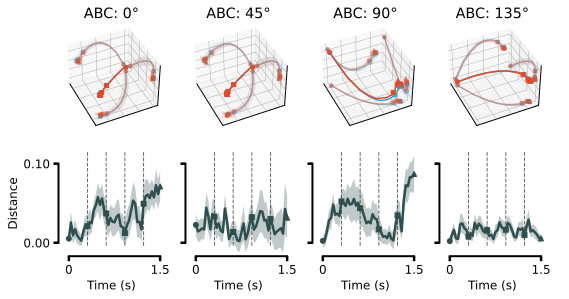

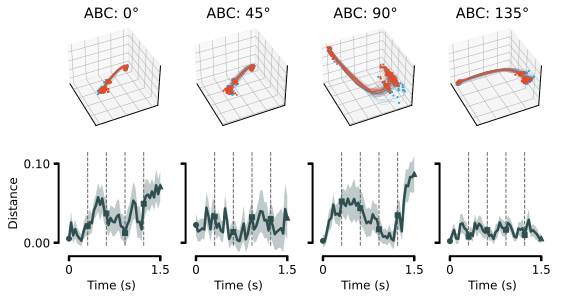

In [19]:
show_proj_factors(model_dir)
show_proj_factors(model_dir, trials=True)

---
## 6. Conclusion

This notebook provides an example for running VaLPACa on calcium imaging data. Notably, to adapt to the resource constraints of Google Colab, the VaLPACa training performed here is insufficient (50 epochs instead 800 epochs). Thus, the results shown should be seen as illustrative and should not be directly interpreted. 